**Importing Libraries**

In [1]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [2]:
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.6 MB/s 


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import LeakyReLU
import cv2
from tqdm import tqdm
import random
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical  

In [5]:
EPOCHS = 70
BATCH_SIZE = 32

**Data Set**

In [6]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
df = pd.read_csv("drive/MyDrive/age_gender.csv")

In [8]:
print("trainset consists of ",df.shape)

trainset consists of  (23705, 5)


In [9]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


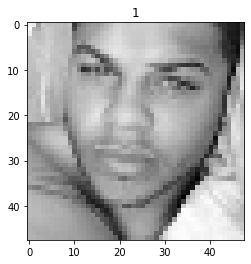

In [10]:
index = 5006
image = np.fromstring(df['pixels'][index], sep = ' ', dtype = np.uint8).reshape((48,48))
plt.title(df['ethnicity'][index])
plt.imshow(image, cmap ="gray")
plt.show()

**Data Generator**

In [11]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 batch_size = 32,
                 input_size=(48, 48, 3),
                 shuffle=True,
                 data_augmentation = False):
        self.df = df
        self.batch_size = batch_size
        self.input_size = input_size
        self.data_augmentation = data_augmentation
        self.var = 1
        
        self.imageGenerator = ImageDataGenerator(
            horizontal_flip = True,
            #vertical_flip = True,
            fill_mode = 'nearest',
            zoom_range = (1, 1.1),
            width_shift_range = 0.1,
            height_shift_range = 0.1,
            rotation_range = 10
        )
        
        self.images = []
        self.age_labels = []        
        self.ethnicity_labels = []
        self.gender_labels = []
        
        for index, row in tqdm(df.iterrows()):
            image = np.fromstring(row['pixels'], sep = ' ', dtype = np.uint8).reshape((48,48))
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            
            self.images.append(image)
            
            self.age_labels.append(row['age'])
            self.ethnicity_labels.append(row['ethnicity'])
            self.gender_labels.append(row['gender'])
            
            
        self.images = np.array(self.images)
        self.age_labels = np.array(self.age_labels).astype(np.float32)
        self.ethnicity_labels = np.array(self.ethnicity_labels).astype(np.float32)
        self.gender_labels = np.array(self.gender_labels).astype(np.float32)
        
        p = np.random.permutation(len(self.age_labels))
        self.images = self.images[p]
        self.age_labels = self.age_labels[p]
        self.ethnicity_labels = to_categorical(self.ethnicity_labels[p], num_classes=5)
        self.gender_labels = self.gender_labels[p]
        
        self.n = len(self.df)
        
    
    def __getitem__(self, index):
        images = []
        
        for i in range(self.batch_size):
            image = self.images[index * self.batch_size + i]
            
            if self.data_augmentation:                
                image = self.imageGenerator.random_transform(image)
                
            images.append(image)
            
        s = slice(self.batch_size * index, (index + 1) * self.batch_size)
        return np.array(images), (self.age_labels[s], self.ethnicity_labels[s], self.gender_labels[s])
    
    def __len__(self):
            
        return self.n // self.batch_size
    
    def on_epoch_end(self):
        
        #Random permutation
        p = np.random.permutation(len(self.age_labels))
        self.images = self.images[p]
        self.age_labels = self.age_labels[p]
        self.ethnicity_labels = self.ethnicity_labels[p]
        self.gender_labels = self.gender_labels[p]

In [12]:
#Divide into train and validation
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
val = df[~msk]

train_dataset = CustomDataGen(train, data_augmentation = True)
val_dataset = CustomDataGen(val)

18948it [00:02, 6439.91it/s]
4757it [00:00, 7051.60it/s]


197
26.0 [0. 0. 1. 0. 0.] 0.0


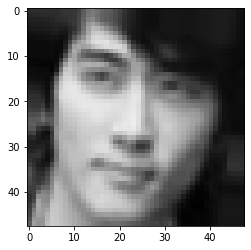

In [13]:
train_dataset.on_epoch_end()
x, y = train_dataset[450]
print(x[21].max())
print(y[0][0], y[1][0], y[2][0])
plt.imshow(x[0])

**Model**

In [14]:
def build_model(input_shape = (48,48,3)):
    
    i = tf.keras.layers.Input(input_shape, dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    
    backbone = tf.keras.applications.vgg16.VGG16(
                include_top=False, weights='imagenet',
                input_tensor=x
            )
    output_layer = backbone.get_layer("block5_conv3").output    
    
    
    def build_age_branch(input_tensor): 
        x = tf.keras.layers.Dense(1024, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1, activation = None, name = 'age_output')(x)
    
        return x
    
    def build_etchnicity_branch(input_tensor): 
        x = tf.keras.layers.Dense(500, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(5, activation = 'softmax', name = 'ethnicity_output')(x)
    
        return x
    
    def build_gender_branch(input_tensor): 
        x = tf.keras.layers.Dense(500, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'gender_output')(x)
    
        return x
    
    x = tf.keras.layers.Flatten()(output_layer)       
    output_age = build_age_branch(x)
    output_ethnicity = build_etchnicity_branch(x)
    output_gender = build_gender_branch(x)
    model = tf.keras.Model(i, [output_age, output_ethnicity, output_gender])
    
    return model

In [15]:
model = build_model()
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 tf.cast (TFOpLambda)           (None, 48, 48, 3)    0           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 48, 48, 3)   0           ['tf.cast[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.nn.bias_add (TFOpLambda) 

**Training**

In [30]:
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4), loss = ['mse', 'categorical_crossentropy', 'binary_crossentropy'], loss_weights = [0.001,0.5,0.5], 
              metrics = {'age_output': 'mean_absolute_error', 'ethnicity_output': 'accuracy', 'gender_output': 'accuracy'})

plateau = tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss', factor=0.3, patience=2, verbose = 1
)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                      patience=5)  # Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True,
                                            mode='min', save_weights_only = True)  # Saves the best version of the model to disk (as measured on the validation data set)
remote_monitor_callback = tf.keras.callbacks.RemoteMonitor(
    root='https://dweet.io', path='/dweet/for/multitask',
    send_as_json=False, field = 'data'
)     

history = model.fit(train_dataset,
            epochs=EPOCHS,
            batch_size = BATCH_SIZE,
            validation_data=val_dataset,
            callbacks = [es, save_best, plateau, remote_monitor_callback])



Epoch 1/70
592/592 [==============================] - 32s 50ms/step - loss: 0.2389 - age_output_loss: 62.8444 - ethnicity_output_loss: 0.2405 - gender_output_loss: 0.1117 - age_output_mean_absolute_error: 6.0991 - ethnicity_output_accuracy: 0.9171 - gender_output_accuracy: 0.9597 - val_loss: 0.6041 - val_age_output_loss: 75.3254 - val_ethnicity_output_loss: 0.7785 - val_gender_output_loss: 0.2790 - val_age_output_mean_absolute_error: 6.3080 - val_ethnicity_output_accuracy: 0.7865 - val_gender_output_accuracy: 0.9088 - lr: 1.0000e-04
Epoch 2/70
592/592 [==============================] - 29s 50ms/step - loss: 0.2387 - age_output_loss: 61.1045 - ethnicity_output_loss: 0.2459 - gender_output_loss: 0.1094 - age_output_mean_absolute_error: 6.0261 - ethnicity_output_accuracy: 0.9164 - gender_output_accuracy: 0.9615 - val_loss: 0.6690 - val_age_output_loss: 168.2836 - val_ethnicity_output_loss: 0.7329 - val_gender_output_loss: 0.2685 - val_age_output_mean_absolute_error: 9.6473 - val_ethnicity

**Evaluating The Model**

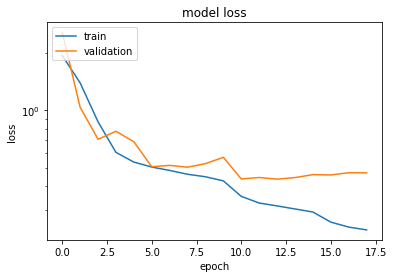

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.yscale('log')
plt.show()

In [17]:
model.save_weights('weights_new.h5')
model.save('model_new.h5')

In [18]:
model.load_weights('weights_new.h5')
model.evaluate(val_dataset)

148/148 [==============================] - 2s 16ms/step - loss: 0.4708 - age_output_loss: 71.1923 - ethnicity_output_loss: 0.5801 - gender_output_loss: 0.2191 - age_output_mean_absolute_error: 6.0684 - ethnicity_output_accuracy: 0.8271 - gender_output_accuracy: 0.9272


[0.4707665741443634,
 71.19225311279297,
 0.5800769329071045,
 0.219071626663208,
 6.068351745605469,
 0.8270692825317383,
 0.9271537065505981]

**Prediction**

In [19]:
names_ethnicity = ['white', 'black', 'asian', 'indian', 'other']

1/1 [==============================] - 0s 232ms/step


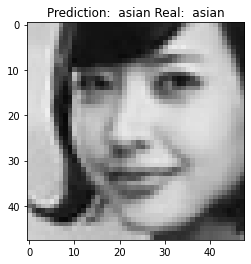

1/1 [==============================] - 0s 15ms/step


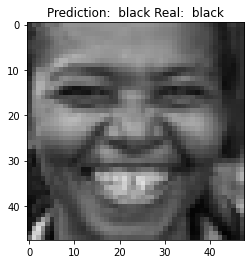

1/1 [==============================] - 0s 17ms/step


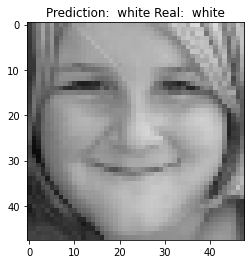

1/1 [==============================] - 0s 16ms/step


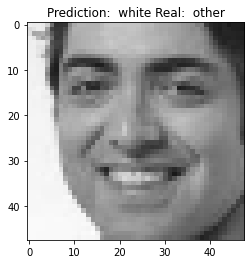

1/1 [==============================] - 0s 16ms/step


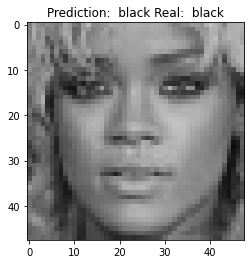

In [20]:
for i in range(20,25):  
  images, labels = val_dataset[i]
  index = 0

  p = model.predict(images)

  gender_predictions = tf.where(p[2] > 0.5, 1, 0)
  plt.title(f'Prediction:  {names_ethnicity[p[1][index].argmax()]} '+
          f'Real:  {names_ethnicity[labels[1][index].argmax()]}')
  plt.imshow(images[index])
  plt.show()

**Predictions for images out of the data set**




1/1 [==============================] - 1s 1s/step


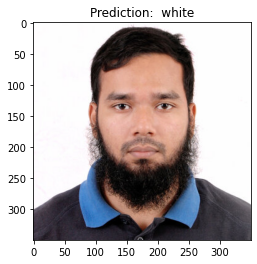

In [26]:
image = tf.keras.preprocessing.image.load_img('rsz_26514.jpg')
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)
plt.title(f'Prediction:  {names_ethnicity[p[0][index].argmax()]}' )
plt.imshow(image)

plt.show()